# Wstęp

Projekt dotyczy klasyfikacji obrazów ze zbioru danych The Simpsons Characters Data (link: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset). 
Zbiór podzielono na 3 podzbiory: treningowy, walidujacy oraz testowy.
Stworzono dwie wersje zbioru danych/modele, które następnie użyto w klasyfikatorach: kNN, CNN, MLP. 

*w przypadku kNN i MLP analizie poddane tylko podzbiory treningowe i testowe

In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path

In [2]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [3]:
def proc_img(filepath): #funckja tworzaca zbior danych z sciezka do pliku i nazwa postaci

    filenames = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='filepath').astype(str)
    filenames = pd.Series(filenames, name='filenames')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, filenames], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

dataset = Path("C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset")
filepaths = list(dataset.glob(r'**/*.jpg'))

df = proc_img(filepaths)

print(f'Liczba zdjęć (ogólna): {df.shape[0]}\n')
print(f'Postacie występujące w zbiorze danych: {df.filenames.unique()}')

Liczba zdjęć (ogólna): 41866

Postacie występujące w zbiorze danych: ['moe_szyslak' 'lisa_simpson' 'kent_brockman' 'sideshow_bob'
 'bart_simpson' 'martin_prince' 'chief_wiggum' 'homer_simpson'
 'milhouse_van_houten' 'abraham_grampa_simpson' 'edna_krabappel'
 'selma_bouvier' 'mayor_quimby' 'nelson_muntz' 'ned_flanders'
 'principal_skinner' 'ralph_wiggum' 'waylon_smithers'
 'charles_montgomery_burns' 'marge_simpson' 'apu_nahasapeemapetilon'
 'krusty_the_clown' 'agnes_skinner' 'barney_gumble' 'comic_book_guy'
 'carl_carlson' 'groundskeeper_willie' 'cletus_spuckler' 'maggie_simpson'
 'lenny_leonard' 'rainier_wolfcastle' 'sideshow_mel' 'snake_jailbird'
 'gil' 'patty_bouvier' 'professor_john_frink' 'miss_hoover' 'disco_stu'
 'otto_mann' 'fat_tony' 'lionel_hutz' 'troy_mcclure']


Interesujący jest fakt, że w podfolderach (odnośnikach do zdjęć już konkretnych bohaterów kreskówki) naszego glownego folderu znajduje się jego dokładna kopia, lecz z pomocą powyższej funkcji nie wliczamy jej do zbioru danych.

C:\Users\Julia\Desktop\studia\6sem\io\simpsons_dataset\simpsons_dataset\lisa_simpson\pic_0967.jpg


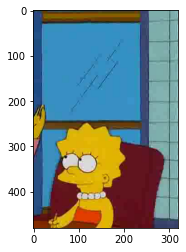

In [4]:
sample = random.choice(df['filepath'])
image = load_img(sample)
plt.imshow(image)
print(sample) #testujemy

In [5]:
#przygotowanie zbioru trenujacego, walidujacego i testujacego 
train_df, test_df = train_test_split(df,test_size=0.2, shuffle = True, random_state= 275056)
train_df, val_df =  train_test_split(train_df,test_size=0.25, shuffle = True, random_state= 275056)

In [6]:
total_train = train_df.shape[0]
total_test = test_df.shape[0]
total_val = val_df.shape[0]
batch_size = 16

CNN klasyfikator

In [7]:
#PARAMETRY PIERWSZEGO MODELU
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(df.filenames.unique()), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2)

callbacks = [earlystop, learning_rate_reduction]

In [9]:
train_datagen = ImageDataGenerator( #normalizacja
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe( #przygotowanie zdjec do modelu
    train_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 25119 validated image filenames belonging to 42 classes.


In [19]:
val_datagen = ImageDataGenerator( #normalizacja
    rescale=1./255,
)

val_generator = val_datagen.flow_from_dataframe( #przygotowanie zdjec do modelu
    val_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 8373 validated image filenames belonging to 42 classes.


In [14]:
example_df = train_df.sample(n=1).reset_index(drop=True) #losowy obrazek do testu
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


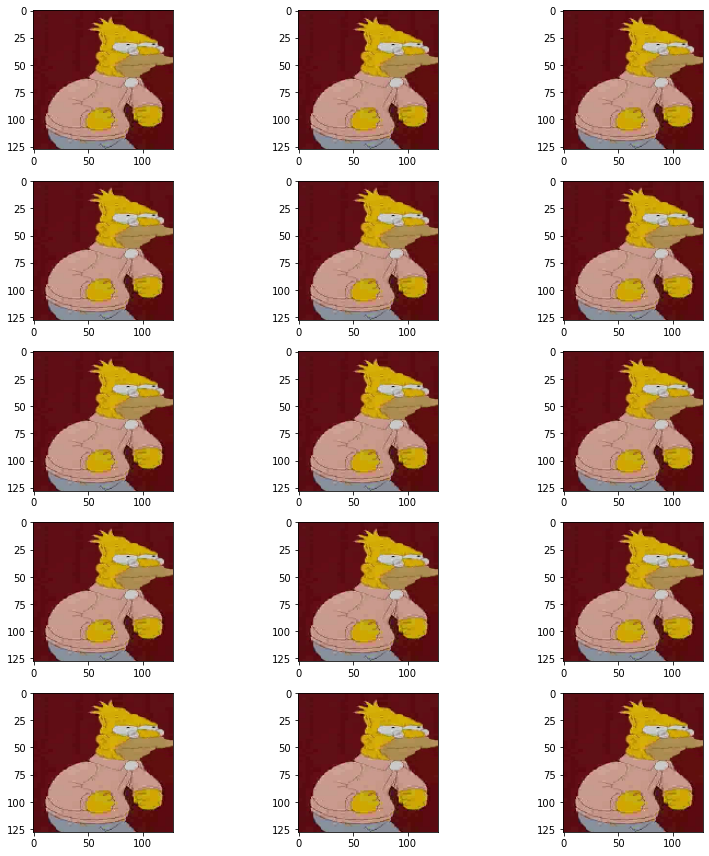

In [15]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show() #test 

In [20]:
epochs=3 if FAST_RUN else 50 #sprawadzamy optymalnosc modelu
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data = val_generator,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
#loss: 0.0390 - accuracy: 0.9877 - lr: 0.0010

Epoch 1/50


<ipython-input-20-0658651fb6e6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


 144/1569 [=>............................] - ETA: 5:48 - loss: 3.3439 - accuracy: 0.2422

KeyboardInterrupt: 

In [ ]:
model.save_weights("model.h5") #zapis

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show() #krzywe uczenia sie

In [ ]:
predict = model.predict(test_generator,steps=np.ceil(total_test/batch_size))
predict = np.argmax(predict,axis=1)

In [ ]:
p = test_generator.classes
q = predict
p = np.array(p)

In [ ]:
tst = train_generator.class_indices
tst = dict((v,k) for k,v in tst.items())
pred = [tst[k] for k in q]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(test_df['filenames'],pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%') #jak bardzo dobry model

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(30, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[i]))
    ax.set_title(f"True: {test_df.filenames.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show() #postacie - ich prawdziwa tozsamosc vs predykcja

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(test_df['filenames'],pred, normalize='true') #macierz predykcji
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(df.filenames.unique())), yticklabels = sorted(set(df.filenames.unique())))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

In [ ]:
from sklearn.metrics import classification_report #jak wygladaja klasyfikacje dla poszczegolnych postaci
class_report = classification_report(test_df['filenames'],pred, zero_division=1)
print(class_report)

In [99]:
#DRUGI MODEL (ROZBUDOWANY)
FAST_RUN = False
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 1

In [ ]:
model.build(input_shape=(64,64, 1))

model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu',input_shape=(64,64, 1))) 
model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df.filenames.unique()), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5)

callbacks = [earlystop, learning_rate_reduction]


In [ ]:
train_datagen = ImageDataGenerator( #normalizacja
    rescale=1./150
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect" #wysokoprztworzone obrazy
)

In [ ]:
val_datagen = ImageDataGenerator( #normalizacja
    rescale=1./150
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect" #wysokoprztworzone obrazy
)

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True) #test
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
 x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect"
)

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
epochs=3 if FAST_RUN else 50 #optymalnosc modelu
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data = val_df,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
# loss: 0.6156 - accuracy: 0.8481 - lr: 0.0010

In [ ]:
model.save_weights("model.h5")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    batch_size = batch_size,
    color_mode='grayscale'
    shuffle = False,
    class_mode = 'categorical'
)

In [ ]:
predict = model.predict(test_generator,steps=np.ceil(total_test/batch_size))
predict = np.argmax(predict,axis=1)

In [ ]:
p = test_generator.classes
q = predict
p = np.array(p)

In [ ]:
tst = train_generator.class_indices
tst = dict((v,k) for k,v in tst.items())
pred = [tst[k] for k in q]

In [ ]:
acc = accuracy_score(test_df['filenames'],pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=8, figsize=(30, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[i]))
    ax.set_title(f"True: {test_df.filenames.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
cf_matrix = confusion_matrix(test_df['filenames'],pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(df.filenames.unique())), yticklabels = sorted(set(df.filenames.unique())))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

In [ ]:
class_report = classification_report(test_df['filenames'],pred, zero_division=1)
print(class_report)

MLP klasyfikator

In [66]:
# I MODEL
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=(16,16), #zmiana wielkosci obrazkow z uwagi, ze trzeba stworzyc liste pikseli
    class_mode='categorical',
    batch_size=batch_size
)

Found 25119 validated image filenames belonging to 42 classes.


In [67]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=(16,16),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 8374 validated image filenames belonging to 42 classes.


In [94]:
pixel_list = [] #lista pikseli
for i in range(int(np.ceil(len(train_df) / batch_size))):
    batch = next(train_generator)
    X_batch = batch[0]  


    for j in range(min(batch_size, len(X_batch))):
        image = X_batch[j]
        pixel_values = image.tolist()
        pixel_list.append(pixel_values)

In [69]:
pixel_list_test = []
for i in range(int(np.ceil(len(test_df) / batch_size))):
    batch = next(test_generator)
    X_batch = batch[0]  


    for j in range(min(batch_size, len(X_batch))):
        image = X_batch[j]
        pixel_values = image.tolist()
        pixel_list_test.append(pixel_values)


In [95]:
X = np.array(pixel_list)
print(X.shape)
num_samples, height, width, channels = X.shape
X = X.reshape(num_samples, height * width * channels)
print(X.shape)
y = np.array(train_df['filenames'])

(25119, 16, 16, 3)
(25119, 768)


In [96]:
X_test = np.array(pixel_list_test)
print(X_test.shape)
num_samples_t, height_t, width_t, channels_t = X_test.shape
X_test = X_test.reshape(num_samples_t, height_t * width_t * channels_t)
print(X_test.shape)
y_test = np.array(test_df['filenames'])

(8374, 16, 16, 3)
(8374, 768)


In [17]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=[300, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=275056)
clf.fit(X, y)

score = clf.score(X, y)
print('Validation accuracy:', score)
#Validation accuracy: 0.1096

Validation accuracy: 0.10967793303873562


In [26]:
#testowy
clf = MLPClassifier(hidden_layer_sizes=[300, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=275056)
clf.fit(X_test, y_test)

score = clf.score(X_test, y_test)
print('Validation accuracy:', score)
#Validation accuracy: 0.9546

Validation accuracy: 0.9546214473369955


In [27]:
#II MODEL
train_datagen = ImageDataGenerator( #normalizacja
    rescale=1./150
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=(16,16),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect" #wysokoprztworzone obrazy
)

Found 25119 validated image filenames belonging to 42 classes.


In [29]:
test_gen = ImageDataGenerator(rescale=1./150)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Julia/Desktop/studia/6sem/io/simpsons_dataset", 
    x_col='filepath',
    y_col='filenames',
    target_size=IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False,
    color_mode='grayscale',
    class_mode = 'categorical'
)

Found 8374 validated image filenames belonging to 42 classes.


In [30]:
pixel_list2 = []
for i in range(int(np.ceil(len(train_df) / batch_size))):
    batch = next(train_generator)
    X_batch = batch[0]  


    for j in range(min(batch_size, len(X_batch))):
        image = X_batch[j]
        pixel_values = image.tolist()
        pixel_list2.append(pixel_values)

In [31]:
pixel_list_test2 = []
for i in range(int(np.ceil(len(test_df) / batch_size))):
    batch = next(test_generator)
    X_batch = batch[0]  


    for j in range(min(batch_size, len(X_batch))):
        image = X_batch[j]
        pixel_values = image.tolist()
        pixel_list_test2.append(pixel_values)


In [32]:
X2 = np.array(pixel_list2)

num_samples, height, width, channels = X2.shape
X2 = X2.reshape(num_samples, height * width * channels)

y2 = np.array(train_df['filenames'])

In [33]:
X2_test = np.array(pixel_list_test2)

num_samples_t, height_t, width_t, channels_t = X2_test.shape
X2_test = X_test.reshape(num_samples_t, height_t * width_t * channels_t)

y2_test = np.array(test_df['filenames'])

In [34]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=[300, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=275056)
clf.fit(X, y)

Validation accuracy: 0.10748835542816194


In [37]:
from sklearn import metrics
y_pred = clf.predict(X2_test)
print(metrics.accuracy_score(y2_test, y2_pred))
#predykcja: 0.7966324337234296

0.7966324337234296


kNN

In [97]:
#uzyjemy modeli z poprzedniego zadania
#I MODEL
from sklearn import *
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

KNeighborsClassifier()

In [98]:
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

AttributeError: 'NoneType' object has no attribute 'split'

In [100]:
#II MODEL
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X2, y2)


NameError: name 'X2' is not defined

In [ ]:
y_pred = clf.predict(X2_test)
print(metrics.accuracy_score(y2_test, y2_pred))

(25119, 768)

Podsumowanie

Na podstawie powyższych wyników, możemy wywnioskować, że mniej przetworzone obrazy zostają lepiej rozpoznawane przez klasyfikatory.

Bibliografia

https://www.tensorflow.org/tutorials/images/cnn?hl=pl
https://realpython.com/knn-python/